# Bagging and Random Forest Models

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a final better prediction. 

In this lab you will work with a widely used ensemble method known as **bootstrap aggregating** or simply **bagging**. Bagging follows a simple procedure:
1. N learners (machine learning models) are defined. 
2. N subsamples of the training data are created by **Bernoulli sampling with replacement**.
3. The N learners are trained on the subsamples of the training data.
4. The ensemble is scored by averaging, or taking a majority vote, of the predictions from the N learners.

**Classification and regression tree models** are most typically used with bagging methods. The most common such algorithm is know as the **random forest**. The random forest method is highly scalable and generally produces good results, even for complex problems. 

Classification and regression trees tend to be robust to noise or outliers in the training data. This is true for the random forest algorithm as well. 

## Example: Iris dataset

As a first example you will use random forest to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [1]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(randomForest)
library(ROCR)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions


Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'ROCR' was built under R version 3.4.4"Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.4.4"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



To get a feel for these data, you will now load and plot them. The code in the cell below does the following:

1. Loads the iris data as a Pandas data frame. 
2. Adds column names to the data frame.
3. Displays all 4 possible scatter plot views of the data. 

Execute this code and examine the results. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


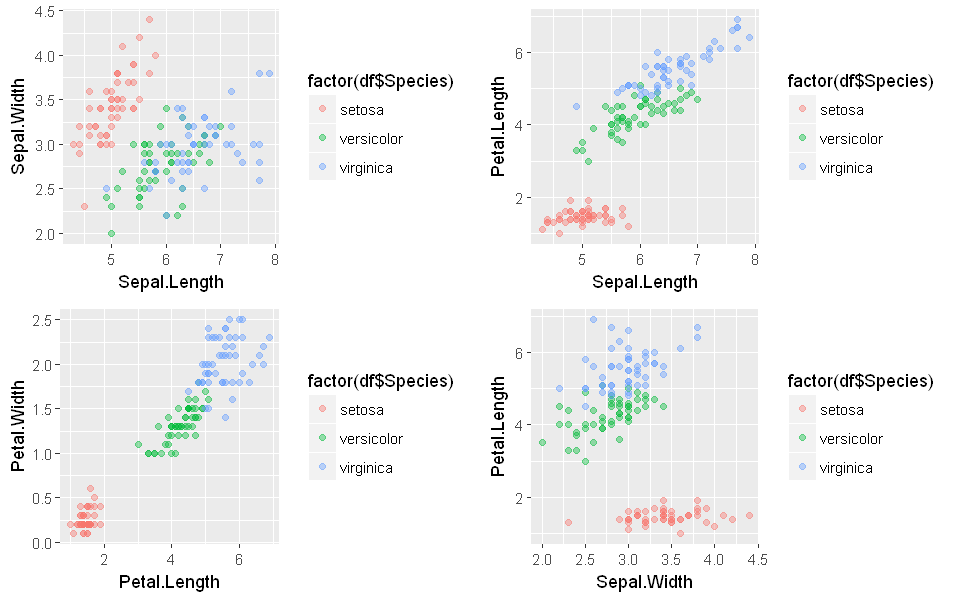

In [2]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris)

You can see that Setosa (in blue) is well separated from the other two categories. The Versicolor (in orange) and the Virginica (in green) show considerable overlap. The question is how well our classifier will separate these categories. 

## Split the dataset

You must now create randomly sampled training and test data sets. The `createDataPartition` function from the R caret package is used  to create indices for the training data sample. In this case 75% of the data will be used  for training the model. Since this data set is small only 48 cases will be included in the test dataset. Execute this code and note the dimensions of the resulting data frame.

In [3]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.50, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 75  5

[1] 75  5

## Scale numeric features

Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables. 

The code in the cell below uses the `preProcess` function from the caret function. The processing is as follows:
1. The preprocessing model object is computed. In this case the processing includes centering and scaling the numeric feature. Notice that this model is fit only ot the training data.
2. The scalling is appled both the test and training partitions.

Execute the code. 

In [4]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.3126284,0.4057850,-1.372230,-1.268093
5,-0.9618666,1.3142589,-1.316478,-1.268093
6,-0.4941843,1.9956143,-1.149224,-1.012772
9,-1.6633901,-0.2755704,-1.316478,-1.268093
10,-1.0787872,0.1786665,-1.260727,-1.395753
11,-0.4941843,1.5413774,-1.260727,-1.268093


Now you will define and fit a random forest model. The code in the cell below defines random forest model with 5 trees using the `RandomForestClassifer` function from the Scikit Learn ensemble  package, and then fits the model. Execute this code.

In [5]:
set.seed(1115)
rf_mod = randomForest(Species ~ ., data = training, ntrees = 5)

Notice that the many hyperparameters of the random forest model object are displayed. 

Next, the code in the cell below performs the following processing to score the test data subset:
1. The test features are scaled using the scaler computed for the training features. 
2. The `predict` method is used to compute the scores from the scaled features. 

Execute this code. 

In [6]:
test$scores = predict(rf_mod, newdata = test)
head(iris, 20)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


It is time to evaluate the model results. Keep in mind that the problem has been made difficult deliberately, by having more test cases than training cases. 

The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from pervious labs to deal with a three category problem. Execute this code and examine the results.

In [7]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         25          0         0
  versicolor      0         23         2
  virginica       0          1        24

Accuracy =  0.96 
 
          setosa versicolor virginica
Precision      1      0.920     0.960
Recall         1      0.958     0.923
F1             1      0.939     0.941


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified with only a few errors. 
2. The overall accuracy is 0.94. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes is quite good.
|
To get a better feel for what the classifier is doing, the code in the cell below displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases, with the species color-coded. Execute this code and examine the results. 

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

Is it possible that a random forest model with more trees would separate these cases better? The code in the cell below uses a model with 40 trees (estimators). This model is fit with the training data and displays the evaluation of the model. 

Execute this code and answer **Question 1** on the course page.

In [8]:
set.seed(1115)
rf_mod = randomForest(Species ~ ., data = training, ntrees = 100)
test$scores = predict(rf_mod, newdata = test)
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         25          0         0
  versicolor      0         23         2
  virginica       0          1        24

Accuracy =  0.96 
 
          setosa versicolor virginica
Precision      1      0.920     0.960
Recall         1      0.958     0.923
F1             1      0.939     0.941


These results are slightly better than for the model with 5 trees. However, this small difference in performance is unlikely to be significant. 

Like most tree-based models, random forest models have a nice property that **feature importance** is computed during model training. Feature importance can be used as a feature selection method. The `varImp` function from the Caret package performs the calculation.  

Execute the code in the cell below to display a plot of the feature importance.

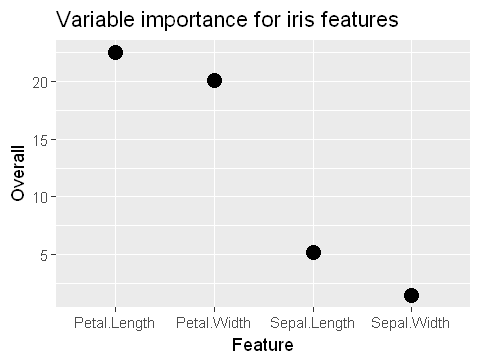

In [9]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(rf_mod)
imp[,'Feature'] = row.names(imp)
ggplot(imp, aes(x = Feature, y = Overall)) + geom_point(size = 4) +
       ggtitle('Variable importance for iris features')

Examine the plot displayed above. Notice that the Speal_Lenght and Sepal_Width have rather low importance. 

Should these features be dropped from the model? To find out, you will create a model with a reduced feature set and compare the results. As a first step, execute the code in the cell below to create training and test datasets using the reduced features.

In [10]:
set.seed(1115)
rf_mod = randomForest(Species ~ Petal.Length + Petal.Width, data = training, ntrees = 100)
test$scores = predict(rf_mod, newdata = test)
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         25          0         0
  versicolor      0         24         1
  virginica       0          1        24

Accuracy =  0.973 
 
          setosa versicolor virginica
Precision      1       0.96      0.96
Recall         1       0.96      0.96
F1             1       0.96      0.96


Once you have executed the code, answer **Question 2** on the course page.

These results are a bit better which may indicate the original model was overfit. Given that a simpler model is more likely to generalize, this model is preferred. 

In [43]:
predict(rf_mod, newdata = test, type = 'prob')[,3]

1     2     4     7     8    12    14    16    19    20    23    24    26 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 
   29    30    32    33    34    35    36    41    44    45    49    50    51 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.036 
   52    53    54    60    62    65    67    68    71    74    76    77    82 
0.000 0.276 0.000 0.024 0.000 0.000 0.000 0.000 0.858 0.012 0.024 0.208 0.000 
   83    84    86    87    88    90    92    95    96    98    99   105   107 
0.000 0.480 0.000 0.012 0.000 0.000 0.024 0.000 0.000 0.000 0.000 1.000 0.072 
  109   111   112   113   114   116   117   119   121   124   125   129   130 
1.000 1.000 1.000 1.000 0.914 1.000 1.000 1.000 1.000 0.942 1.000 1.000 0.664 
  131   132   134   137   138   139   144   146   147   148 
1.000 1.000 0.688 1.000 1.000 0.858 1.000 1.000 0.914 1.000

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which had the following preprocessing:
1. Cleaning missing values.
2. Aggregating categories of certain categorical variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [11]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 
                   'other_credit_outstanding', 'number_loans', 'job_category', 'bad_credit' )]
credit[,'CustomerID'] = NULL
print(dim(credit))
names(credit)

[1] 999  12


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "time_employed_yrs"        "payment_pcnt_income"     
 [7] "time_in_residence"        "property"                
 [9] "other_credit_outstanding" "number_loans"            
[11] "job_category"             "bad_credit"

Nested cross validation is used to estimate the optimal hyperparameters and perform model selection for the random forest model. Since random forest models are efficient to train, 10 fold cross validation is used. Execute the code in the cell below to define inside and outside fold objects. 

In [12]:
#set.seed(1955)
## Randomly sample cases to create independent training and test data
#partition = createDataPartition(credit[,'bad_credit'], times = 1, p = 0.7, list = FALSE)
#training = credit[partition,] # Create the training sample
#dim(training)
#test = credit[-partition,] # Create the test sample
#dim(test)

In [13]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'number_loans')
#preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

#training[,num_cols] = predict(preProcValues, training[,num_cols])
#test[,num_cols] = predict(preProcValues, test[,num_cols])

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,number_loans
2.2464282,0.9483849,-0.86876113,-0.7645835,-0.7035652
-0.7397312,-0.4170067,-0.86876113,0.1414888,-0.7035652
1.7487350,1.6323204,-0.86876113,1.0475610,-0.7035652
0.2556552,0.5655086,0.02505181,1.0475610,1.0276211
1.2510417,2.0477820,-0.86876113,1.0475610,-0.7035652
0.2556552,-0.1552623,0.02505181,1.0475610,-0.7035652


The code in the cell below estimates the best hyperparameters using 10 fold cross validation. There are a few points to note here:
1. In this case, a grid of two hyperparameters is searched: 
  - max_features determines the maximum number of features used to determine the splits. Minimizing the number of features can prevent model over-fitted by induces bias. 
  - min_samples_leaf determines the minimum number of samples or leaves which must be on each terminal node of the tree. Maintaining the minimum number of samples per terminal node is a regularization method. Having too few samples on terminal leaves allows the model training to memorize the data, leading to high variance. Forcing too many samples on the terminal nodes leads to biased predictions. 
2. Since there is a class imbalance and a difference in the cost to the bank of misclassification of a bad credit risk customer, the "balanced" argument is used. The balanced argument ensures that the subsamples used to train each tree have balanced cases. 
3. The model is fit on each set of hyperparameters from the grid. 
4. The best estimated hyperparameters are printed. 

Notice that the model uses regularization rather than feature selection. The hyperparameter search is intended to optimize the level of regularization. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [58]:
recallSummary = function (data, lev = NULL, model = NULL) {
                    out = recall(data$obs, data$pred)  
                    names(out) <- "recall"
                    out
}

fitControl = trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 5,
                           summaryFunction = recallSummary)

set.seed(3344)
rf_fit <- train(factor(bad_credit) ~ ., # make label a factor since classification model
                 data = credit, 
                 metric = "recall", 
                 method = "rf", # Random forest model
                 trControl = fitControl,
                 weight = c(0.9,0.1),
                 verbose = FALSE)
rf_fit

Random Forest 

999 samples
 11 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 899, 899, 899, 899, 899, 899, ... 
Resampling results across tuning parameters:

  mtry  recall   
   2    0.7241492
  13    0.7840424
  24    0.7865709

recall was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 24.

Now, you will run the code in the cell below to perform the outer cross validation of the model. 

In [61]:
score_model = function(df, threshold){
    df$score = ifelse(df$probs[,2] > threshold, 1, 0)
    df
}

binary.eval <- function(df, fold){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))
  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('TrueNeg', 'TruePos')
    
  # Compute AUC with ROCR package
  pred_obj = prediction(df$probs[,2], df$bad_credit)
  AUC = performance(pred_obj,"auc")@y.values[[1]]  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R) 
  data.frame = data.frame(fold = as.character(fold),
                          accuracy = (TP + TN)/(TP + TN + FP + FN),
                          precision = P,
                          recall = R,
                          F1 = F1,
                          AUC = AUC)
 }


Create_Folds = function(df, folds){
    ## Create a vector of the fold assignments
    nrows = nrow(df)
    ncount = nrows/folds
    ## Concatenate vectors of fold number
    fold = rep(1, ncount)
    for(i in seq(2, folds, by = 1)){
        fold = c(fold, rep(i, ncount))
    }
    fold
}

Fit_Mod = function(training, test){
    set.seed(5566)
    rf_mod = randomForest(factor(bad_credit) ~ ., data = training, mtry = 10,
                         classwt = c(0.9, 0.1))
    test$probs = predict(rf_mod, newdata = test, type = 'prob')
    test = score_model(test, 0.5)
    test
}

Cross_Validate_Mod = function(df, folds){
    ## Create a vector of the fold assignments
    fold = Create_Folds(df, folds)
    
    ## Randomly shuffle the rows of the data frame
    shuffle = sample(seq(1, nrow(df), by = 1))
    df = df[shuffle,]
    
    ## Loop over number of folds to fit and evaluate the model
    training = df[fold != 1,]
    test = df[fold == 1, ]
    test = Fit_Mod(training, test)
    evals = binary.eval(test, 1)
    for(i in seq(2, folds, by = 1)){
        training = df[fold != i,]
        test = df[fold == i, ]
        test = Fit_Mod(training, test)
        evals = rbind(evals, binary.eval(test, i))
    }
    
    ## Compute some summary statistics and append to the data rame
    evals = rbind(evals, data.frame(fold = 'Mean',
                          accuracy = mean(evals[,2]),
                          precision = mean(evals[,3]),
                          recall = mean(evals[,4]),
                          F1 = mean(evals[,5]),
                          AUC = mean(evals[,6])))
    
    evals = rbind(evals, data.frame(fold = 'std',
                          accuracy = sd(evals[,2]),
                          precision = sd(evals[,3]),
                          recall = sd(evals[,4]),
                          F1 = sd(evals[,5]),
                          AUC = sd(evals[,6])))
    evals
}

Cross_Validate_Mod(credit, 10)

fold,accuracy,precision,recall,F1,AUC
1,0.75925926,0.69230769,0.5000000,0.58064516,0.7606096
2,0.72727273,0.50000000,0.3703704,0.42553191,0.8011831
3,0.73737374,0.60714286,0.5312500,0.56666667,0.7406716
4,0.70707071,0.46153846,0.4444444,0.45283019,0.7337963
5,0.64646465,0.39285714,0.3793103,0.38596491,0.7054187
6,0.76767677,0.63636364,0.4827586,0.54901961,0.7433498
7,0.68686869,0.53571429,0.4545455,0.49180328,0.6648301
8,0.73737374,0.60714286,0.5312500,0.56666667,0.7395056
9,0.79797980,0.65384615,0.6071429,0.62962963,0.8578974
10,0.76767677,0.56666667,0.6296296,0.59649123,0.7705761


Examine these results. Notice that the standard deviation of the mean of the AUC is more than an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

Now, you will build and test a model using the estimated optimal hyperparameters. As a first step, execute the code in the cell below to create training and testing dataset.

In [ ]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

The code in the cell below defines a random forest model object using the estimated optimal model hyperparameters and then fits the model to the training data. Execute this code.

In [ ]:
nr.seed(1115)
rf_mod = RandomForestClassifier(n_estimators=40, class_weight = "balanced", max_features = 10, min_samples_leaf = 10) 
rf_mod.fit(x_train, y_train)

As expected, the hyperparemeters of the random forest model object reflect those specified. 

The code in the cell below scores and prints evaluation metrics for the model, using the test data subset. 

Execute this code, examine the results, and answer **Question 4** on the course page. 

In [ ]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('True positive    %6d' % conf[0,0] + '          %5d' % conf[0,1])
    print('True negative    %6d' % conf[1,0] + '          %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, scores))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('             Positive   Negative')
    print('Num case    %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1])
    print('Precision   %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1])
    print('Recall      %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1])
    print('F1          %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1])

scores = rf_mod.predict(x_test)
print_metrics(y_test, scores)     

Overall, these performance metrics look quite good. A large majority of negative (bad credit) cases are identified at the expense of significant false positives. The reported AUC is within a standard deviation of the figure obtained with cross validation indicating that the model is generalizing well. 

## Summary

In this lab you have accomplished the following:
1. Used a random forest model to classify the cases of the iris data. A model with more trees had marginally lower error rates, but likely not significantly different.
2. Applied feature importance was used for feature selection with the iris data. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features.  
2. Used 10 fold to find estimated optimal hyperparameters for a random forest model to classify credit risk cases. The model appears to generalize well.  